In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA

import transformers
from transformers import AutoTokenizer, AutoModel, BertConfig
from transformers import AdamW
from transformers import get_scheduler
from transformers import get_linear_schedule_with_warmup
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
embeddings = torch.load('/content/new_card2vec_WOE_emb-300_epochs-20_lr-0.001_bs-128.pt')
embeddings.cpu()

tensor([[ 0.1559,  0.9839,  1.5902,  ..., -0.2291, -0.8667, -1.7474],
        [ 0.8603,  0.1021, -0.2220,  ...,  2.0460,  1.2818, -0.9695],
        [ 2.9035,  3.8097,  0.3557,  ...,  0.7569,  0.0635, -0.5334],
        ...,
        [-0.8207, -2.6411,  0.2796,  ..., -1.9079,  0.9065,  1.4225],
        [ 2.1836,  0.2650,  0.5502,  ...,  0.0559,  0.5236,  0.1906],
        [-0.0283, -0.4314, -0.7257,  ...,  2.9712, -0.7943,  2.4519]])

In [ ]:
import pandas as pd
card_indices = pd.read_pickle(r'card_names_WOE.pkl')[1]

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

torch.Size([329, 300])

In [ ]:
text_data = pd.read_pickle(r'oracle_cards.pkl')

In [ ]:
## what do we need? Some way to automatically take pairs of cards and output
## their similarity according to the model

In [ ]:
card_names = list(card_indices.values())
card_names = [i.strip() for i in card_names]
len(card_names)

329

In [ ]:
set_data = []

for elem in card_names:
  for idx, t in enumerate(text_data):
    if elem in t['name'] and t['oracle_text'] is not None:
      set_data.append(t)
      break
    elif idx == len(text_data) - 1:
      set_data.append(None)

In [ ]:
len(card_names)

329

In [ ]:
len(set_data)

329

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")

In [ ]:
set_data[12]

{'name': "Ashiok's Reaper",
 'mana_cost': '{3}{B}',
 'colors': ['B'],
 'cmc': 4.0,
 'type_line': 'Creature — Nightmare',
 'oracle_text': 'Whenever an enchantment you control is put into a graveyard from the battlefield, draw a card.',
 'power': '3',
 'toughness': '3',
 'loyalty': None,
 'defense': None,
 'layout': 'normal',
 'card_faces': None}

In [ ]:
sentences = [s['oracle_text'] for s in set_data if s is not None]
m_costs = [s['mana_cost'] for s in set_data if s is not None]
null_indices = [i for i in range(len(set_data)) if set_data[i] is None]

In [ ]:
max_len = 0
m_max_len = 0

# For every sentence...
for idx, s in enumerate(sentences):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    if s is not None:
     input_ids = tokenizer.encode(s, add_special_tokens=True)
     m_ids = tokenizer.encode(m_costs[idx], add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    m_max_len = max(m_max_len, len(m_ids))

print('Max sentence length: ', max_len)
print("Max m_costs length: ", m_max_len)

Max sentence length:  131
Max m_costs length:  17


In [ ]:
indices_to_keep = [i for i in range(embeddings.shape[0]) if i not in null_indices] # List of indices that should be kept
y = embeddings[torch.LongTensor(indices_to_keep)]
y.shape

torch.Size([279, 300])

In [ ]:
k = 6
y = y.unsqueeze(-1).repeat(1, 1, k)

for i in range(1, k):
  permutation = torch.randperm(y.shape[0])
  y[:,:,i] = y[permutation,:,i]

In [ ]:
help(tokenizer.encode_plus)

Help on method encode_plus in module transformers.tokenization_utils_base:

encode_plus(text: Union[str, List[str], List[int]], text_pair: Union[str, List[str], List[int], NoneType] = None, add_special_tokens: bool = True, padding: Union[bool, str, transformers.utils.generic.PaddingStrategy] = False, truncation: Union[bool, str, transformers.tokenization_utils_base.TruncationStrategy] = None, max_length: Optional[int] = None, stride: int = 0, is_split_into_words: bool = False, pad_to_multiple_of: Optional[int] = None, return_tensors: Union[str, transformers.utils.generic.TensorType, NoneType] = None, return_token_type_ids: Optional[bool] = None, return_attention_mask: Optional[bool] = None, return_overflowing_tokens: bool = False, return_special_tokens_mask: bool = False, return_offsets_mapping: bool = False, return_length: bool = False, verbose: bool = True, **kwargs) -> transformers.tokenization_utils_base.BatchEncoding method of transformers.models.bert.tokenization_bert_fast.BertTo

In [ ]:
m_dict['input_ids'].shape

torch.Size([1, 17])

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for idx, sent in enumerate(sentences):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 131,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    m_dict = tokenizer.encode_plus(
                        m_costs[idx],                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 17,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(torch.cat((m_dict['input_ids'], encoded_dict['input_ids'][:, 1:]), dim=1))

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(torch.cat((m_dict['attention_mask'], encoded_dict['attention_mask'][:, 1:]), dim=1))



# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Enchanted creatures you control get +2/+2.
Token IDs: tensor([  101,  1063,  1015,  1065,  1063,  1059,  1065,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0, 22454,  7329,  2017,
         2491,  2131,  1009,  1016,  1013,  1009,  1016,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
len(input_ids[0])

147

In [ ]:
# so....what's the move
# add other fields (with separators)
# concat sentences and attention masks
# create uh, three? five? copies of the tensor

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, y)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = len(dataset) - 31
val_size = 31

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  248 training samples
   31 validation samples


In [ ]:
input_ids[6]

tensor([  101,  1063,  1016,  1065,  1063,  1059,  1065,  1063,  1059,  1065,
          102,     0,     0,     0,     0,     0,     0,  3909,  2060,  7329,
         2017,  2491,  2008,  2024, 22454,  2011, 15240,  2015,  2017,  2491,
         2031,  2918,  2373,  1998,  7823,  2791,  1018,  1013,  1018,  1998,
         2031,  3909,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 31

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
class CustomBert(transformers.PreTrainedModel):
    '''Custom model class
       ------------------
       Now the trick is not to inherit the class from `nn.Module` but `transformers.PretrainedModel`
       Also you need to pass the model config during initialisation'''

    def __init__(self, bert):
        super(CustomBert, self).__init__(config=BertConfig.from_pretrained('bert-base-uncased'))
        self.bert = bert

        self.l1 = nn.Linear(768, 768)

        self.mha = nn.MultiheadAttention(embed_dim=768, num_heads=12, dropout=.5)

        self.l2 = nn.Linear(768, 300)

        self.ln = nn.LayerNorm(768)

        self.do = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, sent_id, mask):
        '''For simplicity I have added only one linear layer, you can create any type of network you want'''

        bert_out = self.bert(sent_id, attention_mask=mask)
        o = bert_out.last_hidden_state[:,0,:]
        #o = self.do(o)
        o = self.ln(o + self.mha(o,o,o)[0])
        #o = self.ln(o + self.do(self.relu(self.l1(o))))
        o = self.l2(o)
        return o

In [ ]:
model = CustomBert(bert)
model.cuda()

CustomBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 100

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
training_stats = []

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.

        output_tensor = model(b_input_ids, b_input_mask)
        sim_same = torch.mean(nn.CosineSimilarity(dim=1)(output_tensor, b_labels[:,:,0]))



        sim_other = torch.mean(nn.CosineSimilarity(dim=1)(output_tensor.unsqueeze(-1).repeat(1,1,k -1), b_labels[:,:,1:]))

        loss = nn.functional.relu(1 - sim_same + sim_other)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")


    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output_tensor = model(b_input_ids, b_input_mask)
            sim_same = torch.mean(nn.CosineSimilarity(dim=1)(output_tensor, b_labels[:,:,0]))



            sim_other = torch.mean(nn.CosineSimilarity(dim=1)(output_tensor.unsqueeze(-1).repeat(1,1,k - 1), b_labels[:,:,1:]))

            loss = nn.functional.relu(1 - sim_same + sim_other)



        # Accumulate the validation loss.
        total_eval_loss += loss.item()


    # Report the final accuracy for this validation run.


    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 100 ========
Training...

  Average training loss: 0.99

Running Validation...
  Validation Loss: 0.94

======== Epoch 2 / 100 ========
Training...

  Average training loss: 0.90

Running Validation...
  Validation Loss: 0.88

======== Epoch 3 / 100 ========
Training...

  Average training loss: 0.82

Running Validation...
  Validation Loss: 0.83

======== Epoch 4 / 100 ========
Training...

  Average training loss: 0.76

Running Validation...
  Validation Loss: 0.79

======== Epoch 5 / 100 ========
Training...

  Average training loss: 0.72

Running Validation...
  Validation Loss: 0.77

======== Epoch 6 / 100 ========
Training...

  Average training loss: 0.68

Running Validation...
  Validation Loss: 0.76

======== Epoch 7 / 100 ========
Training...

  Average training loss: 0.65

Running Validation...
  Validation Loss: 0.74

======== Epoch 8 / 100 ========
Training...

  Average training loss: 0.63

Running Validation...
  Validation Loss: 0.73

======== Epoch 

KeyboardInterrupt: ignored

In [ ]:
# cos_sim for any two elements?
#torch.save(model.state_dict(), "/content/BERT_model.pt")

#input_ids[i]



tensor([  101, 22454,  7329,  2017,  2491,  2131,  1009,  1016,  1013,  1009,
         1016,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

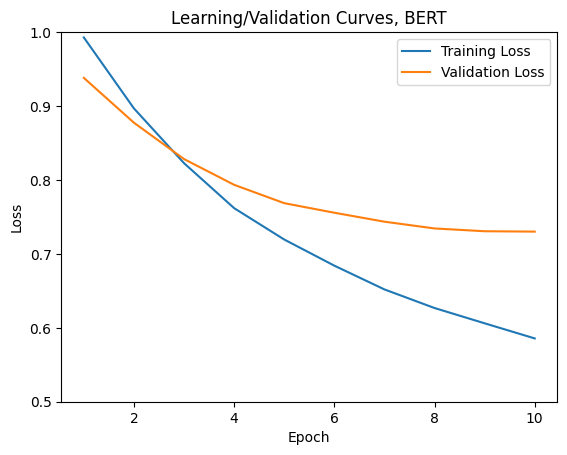

In [ ]:
train_losses = [s['Training Loss'] for s in training_stats]
valid_losses = [s['Valid. Loss'] for s in training_stats]
epochs = [s['epoch'] for s in training_stats]

plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning/Validation Curves, BERT")
plt.ylim(.5, 1.0)
plt.savefig("Learning_Curve_Bert.png")

In [ ]:
attention_masks.shape

torch.Size([279, 131])

In [ ]:
model.load_state_dict(torch.
                      load("/content/BERT_model.pt"))

<All keys matched successfully>

In [ ]:
## Pairwise testing
device = "cuda" if torch.cuda.is_available() else "cpu"

model.cuda()
model.eval()

tensors = []
with torch.no_grad():
  for i in range(len(input_ids)):
    tensor = model(input_ids[i].unsqueeze(0).to(device), attention_masks[i].unsqueeze(0).to(device))
    tensors.append(tensor)

tensor_results = torch.cat(tensors, dim=0)

In [ ]:
tensor_results = torch.Tensor.numpy(tensor_results, force=True)

TypeError: ignored

In [ ]:
card_names = [card_names[i] for i in range(len(card_names)) if set_data[i] is not None]
len(card_names)

279

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(perplexity=20)
tensor_data = tsne.fit_transform(tensor_results)

card_names = [[card] for card in card_names]
tensor_data = np.append(tensor_data, card_names, axis=1)
tensor_data.savetxt("TSNE_data.csv")

AttributeError: ignored

In [ ]:
tensor_data = np.append(tensor_data, colors, axis=1)

ValueError: ignored

In [ ]:
for i in range(len(colors)):
  if len(colors[i]) > 1:
    colors[i] = ["Multi"]
  elif len(colors[i]) == 0:
    colors[i] = ["None"]

In [ ]:
df = pd.DataFrame(tensor_data)
df.to_csv("TSNE_data.csv")

In [ ]:
tensor_norms = nn.functional.normalize(tensor_results, dim=0)
sims = torch.mm(tensor_norms, tensor_norms.t())

<Axes: xlabel='x', ylabel='y'>

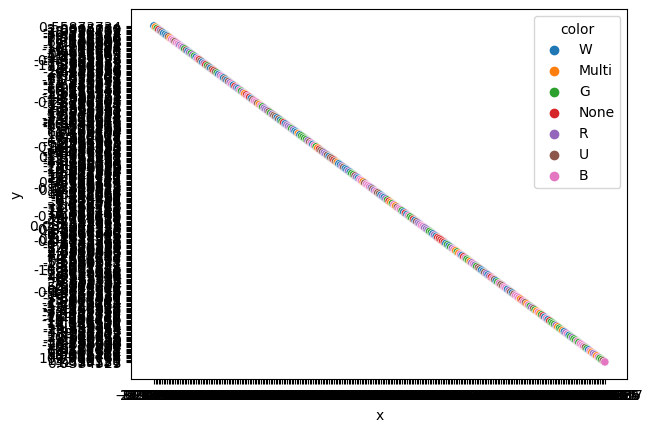

In [ ]:
import seaborn as sns
df = pd.DataFrame(tensor_data, columns=['x', 'y', 'name', 'color'])
sns.scatterplot(df, x='x', y='y', hue='color')

In [ ]:
color_mapping = pd.read_pickle("color_mapping.pkl")
cluster_names = pd.read_pickle('cluster_names.pkl')

print(cluster_names)

{0: 'White', 1: 'Blue', 2: 'Black', 3: 'Red', 4: 'Green', 5: 'Colorless', 6: 'Multicolor', 7: 'Other'}


In [ ]:
color_map = {"W": 0, "B": 2, "G": 4, "U": 1, "R": 3, "None": 5, "Multi": 6}
colors = [color_map[c[0]] for c in colors]

In [ ]:
colors

[['W'],
 ['G', 'R'],
 ['G'],
 [],
 ['R'],
 ['U'],
 ['W'],
 ['W'],
 ['W'],
 ['U'],
 ['R', 'W'],
 ['B'],
 ['B'],
 ['U'],
 ['B'],
 ['B'],
 ['R'],
 ['B'],
 ['R'],
 ['G'],
 ['U'],
 ['W'],
 ['R'],
 ['G'],
 ['R'],
 ['G'],
 ['W'],
 ['B'],
 [],
 ['U'],
 ['W'],
 ['R'],
 [],
 ['G'],
 ['U'],
 ['W'],
 ['U'],
 [],
 ['U'],
 ['G'],
 ['W'],
 ['R'],
 ['B'],
 ['W'],
 ['U'],
 ['W'],
 ['U'],
 ['R'],
 ['B'],
 ['W'],
 [],
 ['R'],
 ['W'],
 ['B'],
 ['G'],
 ['R'],
 ['B', 'W'],
 [],
 ['B'],
 [],
 ['W'],
 ['U'],
 ['B'],
 ['B'],
 ['U'],
 ['B', 'G'],
 ['B'],
 ['G'],
 ['R'],
 ['R'],
 ['R'],
 ['U'],
 ['G'],
 ['R'],
 ['U'],
 ['U'],
 ['W'],
 ['U'],
 ['W'],
 ['G'],
 [],
 ['W'],
 ['R'],
 ['R'],
 ['R'],
 ['G'],
 ['R'],
 ['W'],
 ['W'],
 ['B', 'G'],
 ['W'],
 ['G'],
 ['G'],
 ['G'],
 ['G'],
 ['R'],
 ['U'],
 ['B'],
 ['W'],
 ['B'],
 ['G'],
 ['U', 'W'],
 [],
 ['U'],
 ['U'],
 ['R'],
 ['R'],
 ['U'],
 ['W'],
 ['U'],
 ['U'],
 [],
 ['U'],
 ['R', 'U'],
 ['W'],
 ['W'],
 ['R'],
 ['U'],
 ['W'],
 ['W'],
 ['R'],
 ['W'],
 ['G'],
 ['G'],
 ['

In [ ]:
print(cluster_names)

{0: 'White', 1: 'Blue', 2: 'Black', 3: 'Red', 4: 'Green', 5: 'Colorless', 6: 'Multicolor', 7: 'Other'}


In [ ]:
tensor_data = tensor_data[:, :2].astype("float32")

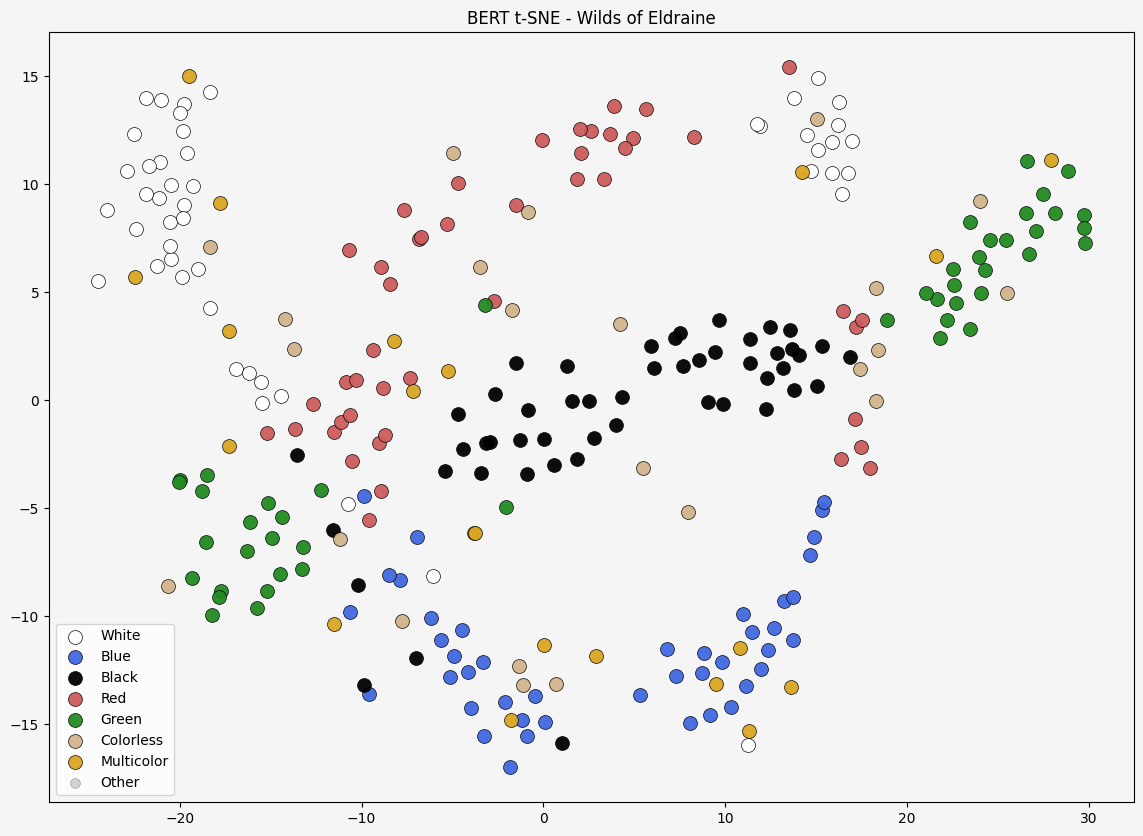

In [ ]:
plt.figure(figsize=(14, 10))
for label, color in color_mapping.items():
  indices = np.array(colors) == label

  if label == 7:  # Underemphasize the 'Other' class
    scatter = plt.scatter(tensor_data[indices, 0], tensor_data[indices, 1],
                          marker='.', color=color, s=200, edgecolors='black', linewidths=0.3, alpha=0.5,
                          label=cluster_names[label])
  else:           # Emphasis all other classes
    scatter = plt.scatter(tensor_data[indices, 0], tensor_data[indices, 1],
                          marker='.', color=color, s=400, edgecolors='black', linewidths=0.5, alpha=0.95,
                          label=cluster_names[label])

plt.gcf().set_facecolor('whitesmoke')
scatter.axes.set_facecolor('whitesmoke')
plt.legend()
plt.title("BERT t-SNE - Wilds of Eldraine")
plt.savefig("BERT_tsne.png")

In [ ]:
#puzzles = pd.read_pickle("LTR_draft_puzzles.pkl")


for puzzle in puzzles:
  score_1 = compare_cards(model, puzzle['context'][0], puzzle['choices'][0])
  score_2 = compare_cards(model, puzzle['context'][0], puzzle['choices'][1])
  if score_1 is None or score_2 is None:
    print("No Result")
    continue

  print(score_1, score_2)
  if score_1 >= score_2:
    print(puzzle['choices'][0])
  else:
    print(puzzle['choices'][1])

tensor([0.5095], device='cuda:0') tensor([0.3640], device='cuda:0')
Relentless Rohirrim
tensor([0.8696], device='cuda:0') tensor([0.4809], device='cuda:0')
Easterling Vanguard
tensor([0.3659], device='cuda:0') tensor([0.0117], device='cuda:0')
Flowering of the White Tree
tensor([0.8696], device='cuda:0') tensor([0.4326], device='cuda:0')
Easterling Vanguard
tensor([-0.0187], device='cuda:0') tensor([-0.0498], device='cuda:0')
Shire Shirriff
tensor([0.3767], device='cuda:0') tensor([0.4436], device='cuda:0')
Stew the Coneys
tensor([0.1130], device='cuda:0') tensor([0.3579], device='cuda:0')
Voracious Fell Beast
tensor([-0.2599], device='cuda:0') tensor([0.1265], device='cuda:0')
Foray of Orcs


In [ ]:
puzzles = pd.read_pickle("LTR_draft_puzzles.pkl")
puzzles[4]['context'] = ["Peregrin Took"]
print(puzzles)

[{'context': ['Rohirrim Lancer'], 'choices': ['Relentless Rohirrim', 'Revive the Shire'], 'solutions': ['Relentless Rohirrm']}, {'context': ['Dunland Crebain'], 'choices': ['Easterling Vanguard', 'Hithlain Knots'], 'solutions': ['Easterling Vanguard']}, {'context': ['Errand-Rider of Gondor'], 'choices': ['Flowering of the White Tree', 'Orcish Medicine'], 'solutions': ['Flowering of the White Tree']}, {'context': ['Dunland Crebain'], 'choices': ['Easterling Vanguard', 'Ithilien Kingfisher'], 'solutions': ['Easterling Vanguard']}, {'context': ['Peregrin Took'], 'choices': ['Shire Shirriff', 'Mirkwood Spider'], 'solutions': ['Shire Shirriff']}, {'context': ['Smite the Deathless'], 'choices': ["Ranger's Firebrand", 'Stew the Coneys'], 'solutions': ["Ranger's Firebrand"]}, {'context': ['Old Man Willow'], 'choices': ['Entish Restoration', 'Voracious Fell Beast'], 'solutions': ['Entish Restoration']}, {'context': ['Rohirrim Lancer'], 'choices': ['Horn of Gondor', 'Foray of Orcs'], 'solutions'

In [ ]:
print(get_card_text("Foray of Orcs", scry_df))

NameError: ignored

In [ ]:
sims = torch.triu(sims, diagonal=1)
print(sims)

tensor([[ 0.0000,  0.0406, -0.0433,  ...,  0.0041, -0.2113, -0.0890],
        [ 0.0000,  0.0000, -0.3958,  ...,  0.3754,  0.0678,  0.4584],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.2941, -0.3245, -0.4782],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.2910,  0.4627],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.2935],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')


In [ ]:
import numpy as np
v, i = torch.topk(1 * sims.cpu().flatten(), 5)
top_5 = np.array(np.unravel_index(i.numpy(), sims.shape)).T

In [ ]:
y[0,:,0]

tensor([ 0.1559,  0.9839,  1.5902,  0.9434,  0.8010,  0.3183, -0.0456, -0.1250,
         1.8921, -2.6493, -1.4396, -2.1557,  0.4127,  0.8651,  2.3141, -0.2989,
        -0.6735,  0.1725, -0.9971,  0.1775, -1.1656, -1.4390,  0.2124, -0.8609,
        -1.1749, -0.1941,  0.8038,  2.1783,  0.3358, -0.7679, -1.1359,  0.8466,
        -0.1260, -0.5093, -0.2572,  1.1915, -0.0562,  0.9246, -2.4059,  0.8186,
        -0.2759, -0.5922, -1.4997,  0.6622, -0.7188,  0.6057, -0.2698,  0.0343,
        -0.1149, -3.1368,  0.0820,  2.3799,  1.6064, -0.3453, -0.7601,  0.1571,
         0.6994, -0.3665,  0.2889,  1.2306,  0.5800,  2.5126, -1.0609,  0.9815,
         0.6300,  0.6999, -2.1176,  0.1753, -1.5527, -0.1524, -3.0380, -0.8899,
         2.1186, -0.3723, -1.8296,  0.1211,  1.1555,  0.4963,  0.8188, -0.2053,
        -0.7380, -1.4771, -0.2394,  1.9492,  0.3868,  1.1689,  1.3070, -0.3248,
        -0.5310,  0.5961,  0.7601, -0.3232,  1.4111, -0.3489,  1.3027,  0.6407,
         0.9220, -0.7972, -0.8295, -0.84

In [ ]:
extant_data = [s for s in set_data if s is not None]

cos_sim = nn.CosineSimilarity(dim=0)

top_5_data = []

for i in range(top_5.shape[0]):
  first_index, second_index = top_5[i]
  first_card, second_card = extant_data[first_index]['name'], extant_data[second_index]['name']
  first_text, second_text = extant_data[first_index]['oracle_text'], extant_data[second_index]['oracle_text']
  card2vec_sim = cos_sim(y[:,:,0][first_index], y[:,:,0][second_index])
  top_5_data.append({"First Card": first_card, "First Text": first_text, "Second Card": second_card, "Second Text": second_text, "Card2Vec Sim": card2vec_sim})

In [ ]:
df = pd.DataFrame(top_5_data)
df.to_csv("top_5_data.csv")

In [ ]:
for i in range(top_5.shape[0]):
  first_index, second_index = top_5[i]
  print(nn.CosineSimilarity(dim=0)(y[first_index], y[second_index]))

tensor(0.7721, device='cuda:0')
tensor(0.8196, device='cuda:0')
tensor(0.7519, device='cuda:0')
tensor(0.8303, device='cuda:0')
tensor(0.5470, device='cuda:0')


In [ ]:
print()

In [ ]:
for i in range(sims.shape[0]):
  sims[i,i] = 0

In [ ]:
pairs = []
for i in input_ids:
  for j in input_ids:
    pairs.append(torch.cat([i,j]))
pairs = torch.stack(pairs, dim=0)
pairs = pairs.reshape(244,244, 128)

In [ ]:
mask_pairs = []
for i in attention_masks:
  for j in attention_masks:
    mask_pairs.append(torch.cat([i,j]))
mask_pairs = torch.stack(mask_pairs, dim=0)
mask_pairs = mask_pairs.reshape(244,244, 128)
#mask_pairs = mask_pairs.reshape(len(attention_masks), len(attention_masks), -1)

In [ ]:
pairs_data = torch.cat([pairs.unsqueeze(-1).to(device), mask_pairs.unsqueeze(-1).to(device), sims.to(device)], -1)

In [ ]:
pairs_data = torch.flatten(pairs_data, start_dim=0, end_dim=1)
pairs_data.shape

torch.Size([59536, 128, 3])

In [ ]:
keep_indices = torch.unique(torch.nonzero(pairs_data[:,:,2], as_tuple=True)[0])

pairs_data = pairs_data[keep_indices]

In [ ]:
sim_scores = pairs_data[:, 0, 2]
input_pairs = pairs_data[:, :, 0].type(torch.IntTensor)
mask_pairs = pairs_data[:, :, 1].type(torch.IntTensor)

In [ ]:
input_pairs.shape

torch.Size([29890, 128])

In [ ]:
type(pairs)

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_pairs, mask_pairs, sim_scores)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset) + 1)
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

23,913 training samples
5,977 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
class CustomBert(transformers.PreTrainedModel):
    '''Custom model class
       ------------------
       Now the trick is not to inherit the class from `nn.Module` but `transformers.PretrainedModel`
       Also you need to pass the model config during initialisation'''

    def __init__(self, bert):
        super(CustomBert, self).__init__(config=BertConfig.from_pretrained('bert-base-uncased'))
        self.bert = bert

        self.l1 = nn.Linear(768, 768)

        self.mha = nn.MultiheadAttention(embed_dim=768, num_heads=8, dropout=.5)

        self.l2 = nn.Linear(768, 1)

        self.ln = nn.LayerNorm(768)

        self.do = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, sent_id, mask):
        '''For simplicity I have added only one linear layer, you can create any type of network you want'''

        bert_out = self.bert(sent_id, attention_mask=mask)
        o = bert_out.last_hidden_state[:,0,:]
        #o = self.ln(o + self.mha(o,o,o)[0])
        o = self.ln(o + self.do(self.relu(self.l1(o))))
        o = self.l2(o)
        return o

In [ ]:
model = CustomBert(bert)

model.cuda()

CustomBert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
training_stats = []

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.

        loss = nn.MSELoss()(model(b_input_ids, b_input_mask), b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += torch.sum(loss).item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")


    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            loss = nn.MSELoss()(model(b_input_ids, b_input_mask), b_labels)


        # Accumulate the validation loss.
        total_eval_loss += loss.item()


    # Report the final accuracy for this validation run.


    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.

    print("  Validation Loss: {0:.3f}".format(avg_val_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  Batch    40  of    748. 
  Batch    80  of    748. 
  Batch   120  of    748. 
  Batch   160  of    748. 
  Batch   200  of    748. 
  Batch   240  of    748. 
  Batch   280  of    748. 
  Batch   320  of    748. 
  Batch   360  of    748. 
  Batch   400  of    748. 
  Batch   440  of    748. 
  Batch   480  of    748. 
  Batch   520  of    748. 
  Batch   560  of    748. 
  Batch   600  of    748. 
  Batch   640  of    748. 
  Batch   680  of    748. 
  Batch   720  of    748. 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



  Average training loss: 0.029

Running Validation...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  Validation Loss: 0.020

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    748. 
  Batch    80  of    748. 
  Batch   120  of    748. 
  Batch   160  of    748. 
  Batch   200  of    748. 
  Batch   240  of    748. 
  Batch   280  of    748. 
  Batch   320  of    748. 
  Batch   360  of    748. 
  Batch   400  of    748. 
  Batch   440  of    748. 
  Batch   480  of    748. 
  Batch   520  of    748. 
  Batch   560  of    748. 
  Batch   600  of    748. 
  Batch   640  of    748. 
  Batch   680  of    748. 
  Batch   720  of    748. 

  Average training loss: 0.023

Running Validation...
  Validation Loss: 0.022

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    748. 
  Batch    80  of    748. 
  Batch   120  of    748. 
  Batch   160  of    748. 
  Batch   200  of    748. 
  Batch   240  of    748. 
  Batch   280  of    748. 
  Batch   320  of    748. 
  Batch   360  of    748. 
  Batch   400  of    748. 
  Batch   440  of    748. 
  Batch   480  of    748. 

In [ ]:
scry_df = pd.DataFrame(text_data)

def get_card_text(name, df):
    card = df[df['name'].str.contains(name)]
    for t in card['oracle_text'].values:
      if t is not None:
        return t
    return None

def get_card_cost(name, df):
    card = df[df['name'].str.contains(name)]
    for t in card['mana_cost'].values:
      if t is not None:
        return t
    return None

def compare_cards(model, card1, card2):
    card1_text = get_card_text(card1, scry_df)
    card2_text = get_card_text(card2, scry_df)

    card1_cost = get_card_cost(card1, scry_df)
    card2_cost = get_card_cost(card2, scry_df)

    if card1_text is None or card2_text is None:
      return

    model.eval()

    card1_dict = tokenizer.encode_plus(
                        card1_text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 131,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )



    card1_m_dict = tokenizer.encode_plus(
                        card1_cost,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 17,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    card1_tokens = torch.cat((card1_m_dict['input_ids'], card1_dict['input_ids'][:, 1:]), dim=1).to(device)
    card1_mask = torch.cat((card1_m_dict['attention_mask'], card1_dict['attention_mask'][:, 1:]), dim=1).to(device)


    card2_dict = tokenizer.encode_plus(
                        card2_text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 131,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )


    card2_m_dict = tokenizer.encode_plus(
                        card2_cost,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 17,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    card2_tokens = torch.cat((card2_m_dict['input_ids'], card2_dict['input_ids'][:, 1:]), dim=1).to(device)
    card2_mask = torch.cat((card2_m_dict['attention_mask'], card2_dict['attention_mask'][:, 1:]), dim=1).to(device)


    with torch.no_grad():
      card1_tensor = model(card1_tokens, card1_mask)
      card2_tensor = model(card2_tokens, card2_mask)

    return nn.CosineSimilarity(dim=1)(card1_tensor, card2_tensor)

In [ ]:
model.eval()

for card in text_data:
  if "Hatching Plans" in card['name']:
    print(card['oracle_text'])

None
When Hatching Plans is put into a graveyard from the battlefield, draw three cards.


In [ ]:
card = scry_df[scry_df['name'].str.contains("Hatching")]
print(len(card['oracle_text'].values))

2


In [ ]:
eval_pairs = pd.read_pickle('WOE_eval_pairs.pkl')

values = []

for pair in eval_pairs['dissimilar']['names']:
  print(pair)
  result = compare_cards(model, pair[0], pair[1])
  if result is not None:
    score = result.item()
    values.append(score)
    print(score)

print(sum(values) / len(values))

('Ash, Party Crasher', 'Greta, Sweettooth Scourge')
0.46398112177848816
('Syr Armont, the Redeemer', 'Obyra, Dreaming Duelist')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-0.14031532406806946
('Sharae of Numbing Depths', 'Ruby, Daring Tracker')
-0.13473236560821533
('Johann, Apprentice Sorcerer', 'Neva, Stalked by Nightmares')
-0.4019918143749237
('Totentanz, Swarm Piper', 'Troyan, Gutsy Explorer')
0.12045540660619736
-0.018520595133304597


{'names': [('Hopeful Vigil', 'Stockpiling Celebrant'),
  ('The Princess Takes Flight', 'Stockpiling Celebrant'),
  ("Johann's Stopgap", 'Hatching Plans'),
  ('Ice Out', 'Hatching Plans'),
  ('Barrow Naughty', 'Faerie Dreamthief'),
  ('Faerie Fencing', 'Faerie Dreamthief'),
  ('Bespoke Battlegarb', 'Edgewall Pack'),
  ('Belligerent of the Ball', 'Edgewall Pack'),
  ('Hamlet Glutton', 'Hollow Scavenger'),
  ('Welcome to Sweettooth', 'Hollow Scavenger')],
 'ids': [(122, 256),
  (281, 256),
  (138, 117),
  (128, 117),
  (16, 76),
  (77, 76),
  (24, 64),
  (18, 64),
  (114, 121),
  (316, 121)]}

In [ ]:
[0.7402505278587341, 0.7287606596946716, 0.8913463950157166, 0.9347384572029114

,name,mana_cost,colors,cmc,type_line,oracle_text,power,toughness,loyalty,defense,layout,card_faces
9394,Hollow Scavenger // Bakery Raid,{2}{G} // {G},[G],3.0,Creature — Wolf // Sorcery — Adventure,None,3,2,None,None,adventure,"[{'name': 'Hollow Scavenger', 'mana_cost': '{2..."


In [ ]:
print(get_card_text("Totentanz, Swarm Piper", scry_df))

None


In [ ]:
scry_df[scry_df['name'].str.contains("Troyan, Gutsy Explorer")]

,name,mana_cost,colors,cmc,type_line,oracle_text,power,toughness,loyalty,defense,layout,card_faces
293,"Troyan, Gutsy Explorer",{1}{G}{U},"[G, U]",3.0,Legendary Creature — Vedalken Scout,{T}: Add {G}{U}. Spend this mana only to cast ...,1,3,None,None,normal,None


In [ ]:
colors = [s['colors'] for s in set_data if s is not None]

In [ ]:
help(model.forward())

TypeError: ignored

In [ ]:
import os
os.path.getsize('/content/BERT_model.pt')

450754511

In [ ]:
#evaluations: t-SNE, WOE pairs, lotr pairs, loss curve, top 5 most similar/most dissimilar